# Исследование объявлений о продаже квартир

### Exploring the data!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
try:
    data = pd.read_csv("/datasets/real_estate_data.csv", sep = "\t")
except:
    data = pd.read_csv("real_estate_data.csv", sep = '\t') # for local machine

pd.set_option('display.max_columns', None) # displaying all the columns

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### 2. Preprocessing

Избавимся от явных и неявных дубликатов, если таковые имеются.

In [5]:
data = data.drop_duplicates().reset_index(drop = True) # dropping the duplicates
data.duplicated().sum()

0

In [6]:
data['locality_name'] = data['locality_name'].replace({'ё' : 'е'}, regex = True)

In [7]:
data.locality_name.value_counts()

Санкт-Петербург                        15721
поселок Мурино                           556
поселок Шушары                           440
Всеволожск                               398
Пушкин                                   369
                                       ...  
садовое товарищество Приладожский          1
деревня Трубников Бор                      1
деревня Сижно                              1
поселок городского типа Кондратьево        1
садовое товарищество Садко                 1
Name: locality_name, Length: 330, dtype: int64

### 2.1 Taking a glance at missing values

Посмотрим на пропущенные значения.

In [8]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Пропущенные значения в:**
1. `floors_total`, `locality_name` - мало пропущенных значений, скорее всего можно будет просто исключить эти объявления 
2. `ceiling_height` - подозрительно много пропущенных значений, надо будет проверить 
3. `living_area` - 10% пропущенных значений 
4. `is_apartment` - скорее всего значениями NaN просто обозначено, что это не апартаменты, посмотрим далее 
5. `kitchen_area` - может быть не указано значение, потому что, например, в студиях нет отдельной кухни, посмотрим далее
6. `balcony` - скорее всего та же история, что и с `is_apartment`
7. `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest` - скорее всего NaN просто значит, что рядом объекта нет, поэтому не будем их трогать
8. `days_exposition` - скорее всего пропуски из-за того, что объявления еще не сняты с площадки 

### 2.2. Fixing missing values

 **2.2.1.** Мы можем удалить строки с пропусками в `floors_total` и `locality_name`, потому что здесь пропущенных значений очень мало, и они не повлияют на наше исследование.

In [9]:
data = data.dropna(subset = ['floors_total', 'locality_name'])

print(f"Amount of NaNs in floors_total: {data['floors_total'].isna().sum()}")
print(f"Amount of NaNs in locality_name: {data['locality_name'].isna().sum()}")

Amount of NaNs in floors_total: 0
Amount of NaNs in locality_name: 0


**2.2.2.** Посмотрим на столбец `ceiling_height`.

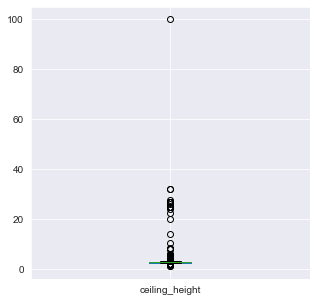

In [10]:
sns.set_style('darkgrid')
data.boxplot(column = ['ceiling_height'], figsize = (5,5))
plt.show()

In [11]:
data['ceiling_height'].describe()

count    14481.000000
mean         2.771283
std          1.261983
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

В общем и целом, несмотря на большое кол-во выбросов, среднее и медиана практически одинаковые, можем заполнить пропуски медианой, с выбросами разберемся далее.

In [12]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

print(f"Amount of NaNs in floors_total: {data['ceiling_height'].isna().sum()}")

Amount of NaNs in floors_total: 0


**2.2.3.** Мы не можем просто так заполнить `living_area` средним или медианой, потому что это очень сложный параметр, который зависит от цены, местоположения и т.д., то есть нужен более детальный анализ. *Оставим пропущенные значения.*

**2.2.4.** Посмотрим на `is_apartment`.

In [13]:
display(data['is_apartment'].value_counts())
print(f"Amount of NaNs in is_apartment column: {data['is_apartment'].isna().sum()}")

False    2710
True       50
Name: is_apartment, dtype: int64

Amount of NaNs in is_apartment column: 20805


Скорее всего такое большое количество пропусков связано с тем, что люди просто не указывают в объявлении, является ли квартира апартаментами или нет, так как данный критерий не является приоритетным. *Оставим пропущенные значения*

**2.2.5.** Посмотрим уникальные значения `kitchen_area`. Есть предположения, что пропущенные значения `kitchen_area` связаны со стобцом `studio`, ведь в студиях нет отдельной кухни, давайте это проверим.

In [14]:
filt = (data['studio'] == True)
data[filt]['kitchen_area']

144     NaN
440     NaN
608     NaN
697     NaN
716     NaN
         ..
22867   NaN
22877   NaN
23210   NaN
23554   NaN
23637   NaN
Name: kitchen_area, Length: 146, dtype: float64

Похоже, что теория подтвердилась, заполним пропуски в столбце `kitchen_area` нулем, где `studio` == True.

In [15]:
data.loc[filt,'kitchen_area'] = data.loc[filt,'kitchen_area'].fillna(0)
data[data['studio'] == True]['kitchen_area']

144      0.0
440      0.0
608      0.0
697      0.0
716      0.0
        ... 
22867    0.0
22877    0.0
23210    0.0
23554    0.0
23637    0.0
Name: kitchen_area, Length: 146, dtype: float64

In [16]:
print(f"Amount of NaNs in kitchen_area: {data['kitchen_area'].isna().sum()}")

Amount of NaNs in kitchen_area: 2076


Можно предположить, что размер кухни зависит от размера квартиры, тогда можно будет адекватно заполнить оставшиеся пропуски в `kitchen_area`, посмотрим корреляцию.

In [17]:
print(f"Correlation between total and kitchen area is {data['total_area'].corr(data['kitchen_area'])}")

Correlation between total and kitchen area is 0.6120447229237874


Корреляция составляет **0.61**, то есть какая-то корреляция есть, но так как у нас пропуски составляют 10%, то оставим их как есть.

**2.2.6.** Если человек не указал число балконов в `balcony` — скорее всего, их нет, либо число балконов является неприоритетным критерием, который мало кто заполняет, поэтому заполним пропущенные значения нулём.

In [18]:
data['balcony'] = data['balcony'].fillna(0)
print(f"Amount of NaNs in balcony column: {data['balcony'].isna().sum()}")

Amount of NaNs in balcony column: 0


**2.2.7.** Обработаем значения в столбцах `airports_nearest`, `cityCenters_nearest`, `parks_nearest`, `ponds_nearest`. 

Как было сказано ранее, NaN значит то, что просто либо нет информации, либо то, что попросту расстояние до аэропорт, центра города, водоема или парка слишком большое.

In [19]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1865
floor                       0
is_apartment            20805
studio                      0
open_plan                   0
kitchen_area             2076
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

### 2.2. Вывод
Удалось обработать достаточно большое количество пропусков, но не все, поэтому это надо будет учесть в дальнейшем исследовании.

### 2.3. Changing columns' types

In [20]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment             object
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

Изменим тип в столбцах `floors_total`, `is_apartment`, `balcony`, `first_day_exposition`.

In [21]:
columns = ['floors_total', 'balcony', 'total_area']
for column in columns:
    data[column] = data[column].astype('int64')
data['is_apartment'] = data['is_apartment'].astype(bool)
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])

In [22]:
data.dtypes

total_images                     int64
last_price                     float64
total_area                       int64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

### 2.3. Вывод
Изменили тип в столбцах `floors_total`, `is_apartment`, `balcony`. Остальные столбцы оставили как было. Не меняем значения в некоторых столбцах с `float64` на `int64` из-за пропущенных значений.

### 3. Расчёты и добавление результатов в таблицу

#### 3.1 Добавим новые столбцы в таблицу для дальнейшего удобства в проведении исследовательского анализа.

**3.1.1.** Столбец, который будет отображать стоимость 1 квадратного метра. Округлим, так как считать копейки нам не к чему.

In [23]:
data['price_per_metre'] = data['last_price'] / data['total_area']
data['price_per_metre'] = data['price_per_metre'].round()

**3.1.2.** Столбцы, отвечающие за день недели, месяц и год публикации объявления.

In [24]:
data['first_day_exposition'].dt.weekday.value_counts()

3    4276
1    4163
4    3980
2    3948
0    3596
5    1919
6    1683
Name: first_day_exposition, dtype: int64

In [25]:
def weekdays(row): # function for replacing weekdays' numbers with actual names
    if row == 0: return 'Monday'
    if row == 1: return 'Tuesday'
    if row == 2: return 'Wednesday'
    if row == 3: return 'Thursday'
    if row == 4: return 'Friday'
    if row == 5: return 'Saturday'
    if row == 6: return 'Sunday'
    return 'None'

data['weekday_exposition'] = data['first_day_exposition'].dt.weekday
data['weekday_exposition'] = data['weekday_exposition'].apply(weekdays)

In [26]:
data['month_exposition'] = data['first_day_exposition'].dt.month

In [27]:
data['year_exposition'] = data['first_day_exposition'].dt.year

**3.1.3.** Столбец, отвечающий за этаж квартиры.

In [28]:
def level(row):
    row1 = row['floor']
    row2 = row['floors_total']
    
    if row1 == 1:
        return 'First'
    elif row1 == row2:
        return 'Last'
    else:
        return 'Other'
    
data['floor_categorized'] = data.apply(level, axis = 1)

**3.1.4.** Столбцы, отвечающие за отношение кухни и жилой площади к общей площади.

In [29]:
data['kitchen_to_total_ratio'] = (data['kitchen_area'] / data['total_area']).round(decimals = 2)
data['living_to_total_ratio'] = (data['living_area'] / data['total_area']).round(decimals = 2)

### 4. Analyzing enormous values

**4.1.** Изучим следующие параметры: *площадь, цена, число комнат, высота потолков.*

**4.1.1** Изучим площадь.

In [30]:
data['total_area'].describe()

count    23565.000000
mean        60.095226
std         35.668758
min         12.000000
25%         40.000000
50%         52.000000
75%         69.000000
max        900.000000
Name: total_area, dtype: float64

Видим довольно большой выброс 900, при 3 квартиле == 75%, построим гистограмму и boxplot для лучшего вида.

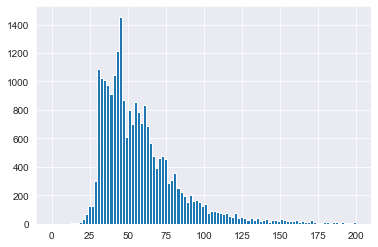

In [31]:
data['total_area'].hist(bins = 100, range = (0,200))
plt.show()

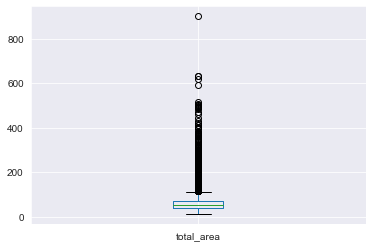

In [32]:
data.boxplot('total_area')
plt.show()

В целом, распределение близко к нормальному, но существует огромное количество выбросов, посмотрим сколько их на самом деле в соотношении с общим числом данных. Будем считать, что со 105 кв.метров. уже не квартира.

In [33]:
data.loc[data['total_area'] > 105, 'total_area'].count()/data['total_area'].count()

0.06713346064078082

Всего лишь 6%, избавимся от записей и посмотрим на новое распределение.

In [34]:
data = data[data['total_area'] < 105]

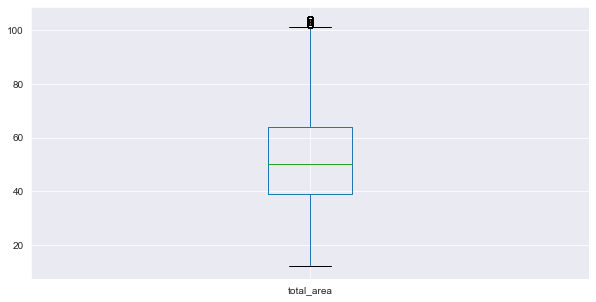

In [35]:
data.boxplot('total_area', figsize=(10,5))
plt.show()

**4.1.2** Изучим цены.

In [36]:
data.loc[:, 'last_price'] /= 1000000

In [37]:
data['last_price'].describe()

count    21939.000000
mean         5.146628
std          3.071685
min          0.430000
25%          3.350000
50%          4.490000
75%          6.150000
max         53.000000
Name: last_price, dtype: float64

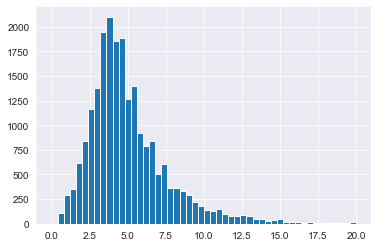

In [38]:
data['last_price'].hist(bins = 50, range = (0,20))
plt.show()

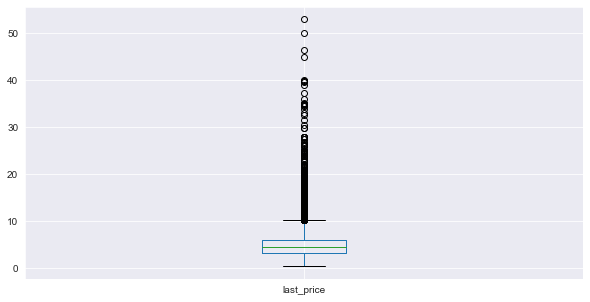

In [39]:
data.boxplot('last_price', figsize = (10,5))
plt.show()

В целом все хорошо, только не помешало бы избавиться от выбросов, то есть от значений, где квартира стоит >12 млн. Избавимся от них и посмотрим на измененный boxplot.

In [40]:
data = data[data['last_price'] < 12]

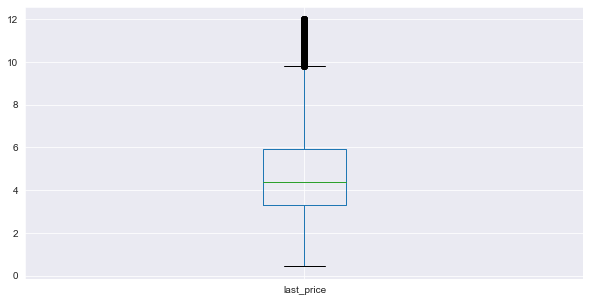

In [41]:
data.boxplot('last_price', figsize = (10,5))
plt.show()

**4.1.3.** Изучение числа комнат.

In [42]:
data['rooms'].describe()

count    21219.000000
mean         1.899760
std          0.875774
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

В целом, распределение нормальное, аномальных значений нет, не помешает избавиться от нулей в числе комнат.

In [43]:
data = data[data['rooms'] != 0]

**4.1.4.** Распределение высоты потолков.

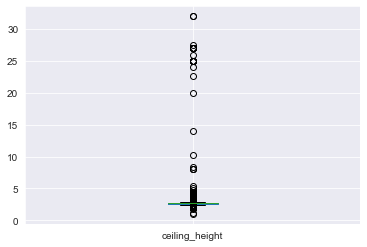

In [44]:
data.boxplot('ceiling_height')
plt.show()

Будем считать, что высота потолков в квартире не может быть больше 4  и меньше 2 метров, избавимся от этих значений и построим гистограмму.

In [45]:
data = data[(data['ceiling_height'] < 5) & (data['ceiling_height'] > 2)]

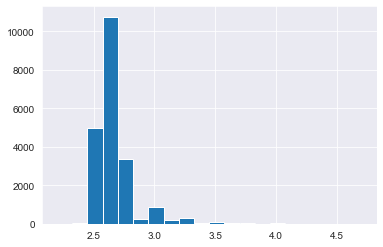

In [46]:
data['ceiling_height'].hist(bins = 20)
plt.show()

**4.2.** Отдельно изучим время продажи квартиры, выясним, сколько обычно времени занимает продажа, а так же при каких значениях продажи можно считать быстрыми или медленными.

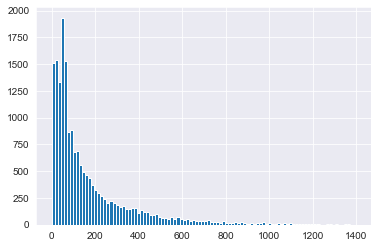

In [47]:
data['days_exposition'].hist(bins = 100, range = (0,1400))
plt.show()

Заметим типичное распределение Пуассона с пиком около 100 дней, посмотрим конкретнее на квартили.

In [48]:
data['days_exposition'].describe()

count    18422.000000
mean       171.964879
std        210.023214
min          1.000000
25%         44.000000
50%         91.000000
75%        217.000000
max       1580.000000
Name: days_exposition, dtype: float64

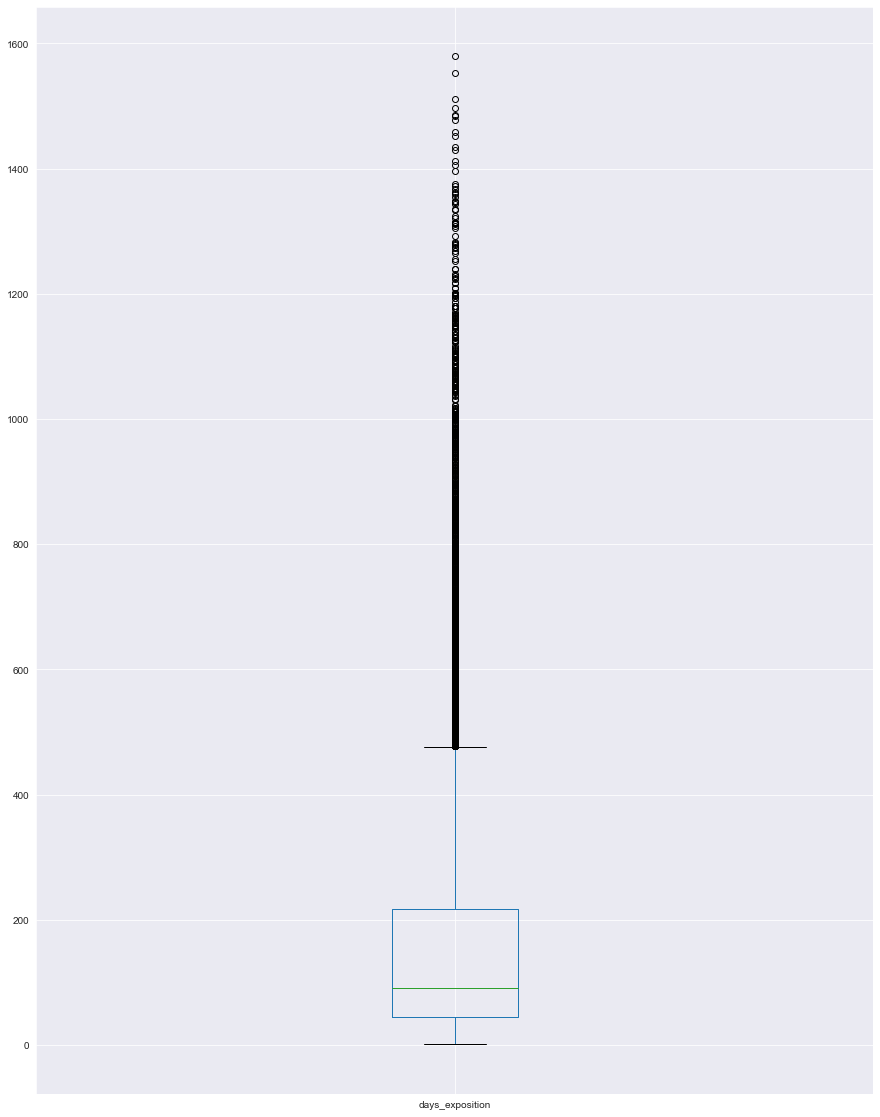

In [49]:
data.boxplot(column = 'days_exposition', figsize = (15,20))
plt.show()

В основном выбросы после 500 дней, а 1ый квартиль = 45, поэтому можно примерно сказать по boxplot, что при **> 500 days** - продажи очень долгие, а **< 45 days** - очень быстрые. В среднем продажи происходят в интервале **[45;230]**

Самые редкие значения, исходя из boxplot, начинаются примерно с 600 дней, поэтому отбросим все значения > 600.
Будем считать, что 600 дней (или же 2 года) - это крайний срок для продажи квартиры.

In [50]:
data = data[data['days_exposition'] < 600]

### 5. Исследовательский анализ данных

#### 5.1. Давайте узнаем, какие факторы влияют больше всего на стоимость квартиры.

Возьмем столбцы:

- `total_area`, `rooms`, `floor_categorized` (first and last), `cityCenters_nearest`.

- `weekday_exposition`, `month_exposition`, `year_exposition`.

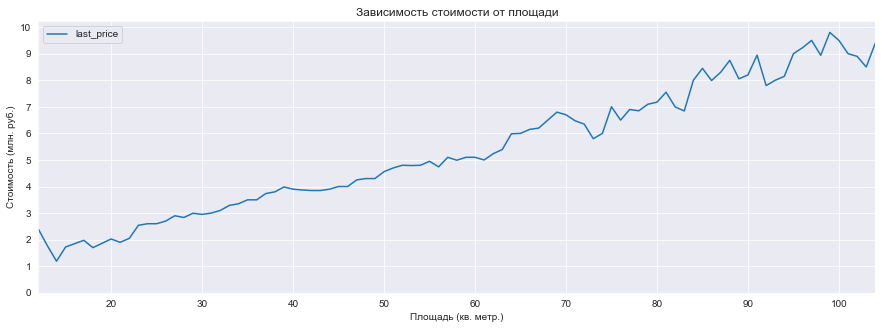

In [53]:
(data.sort_values('total_area').pivot_table(index = 'total_area', values = 'last_price', aggfunc = 'median').
plot(figsize = (15,5)))

sns.set_style('darkgrid')
plt.title('Зависимость стоимости от площади')
plt.xticks(range(20,110, 10))
plt.yticks(range(0,11, 1))
plt.xlabel('Площадь (кв. метр.)')
plt.ylabel('Стоимость (млн. руб.)')

plt.show()

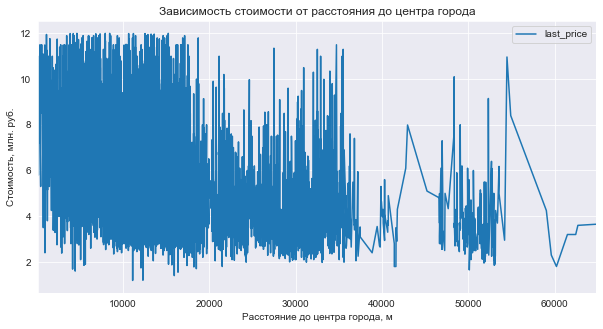

In [54]:
(data.sort_values('cityCenters_nearest').
plot(x = 'cityCenters_nearest', y = 'last_price', grid = True, figsize = (10,5)))

sns.set_style('darkgrid')
plt.title('Зависимость стоимости от расстояния до центра города')
plt.xlabel('Расстояние до центра города, м')
plt.ylabel('Стоимость, млн. руб.')

plt.show()

Можно открыто пронаблюдать прямую зависимость и не только.
- Чем больше площадь, чем больше стоимость
- Оказалось, что на стоимость расстояние от центра города цена не влияет так сильно, на этом также можно убедиться с помощью корреляции, которая составляет всего -0.3

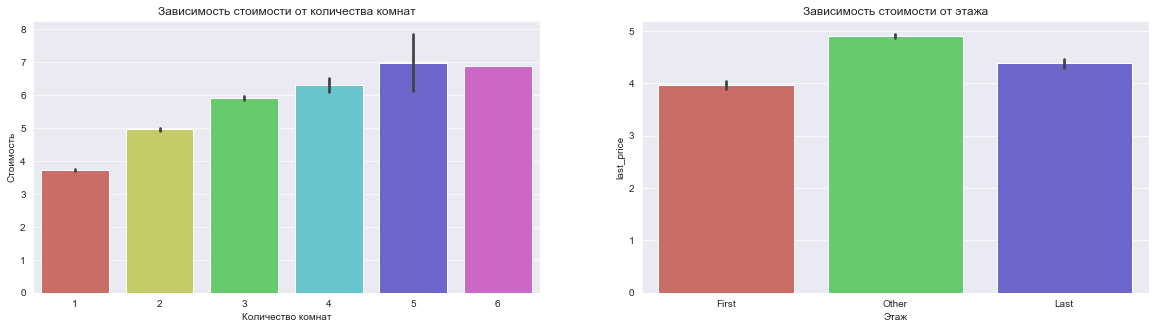

In [55]:
sns.set_style('darkgrid')
plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
sns.barplot(data = data, x = 'rooms', y = 'last_price', palette = 'hls')
plt.title('Зависимость стоимости от количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Стоимость')


plt.subplot(1,2,2)
sns.barplot(data = data, x = 'floor_categorized', y = 'last_price', palette = 'hls')
plt.title('Зависимость стоимости от этажа')
plt.xlabel('Этаж')


plt.show()

Наглядно с помощью диаграммы рассеяния видно, что с увеличением кол-ва комнат, растет и цена, а жить на первом или последнем этаже дешевле, чем на всех остальных.

Теперь рассмотрим столбцы `weekday_exposition`, `month_exposition`, `year_exposition`.

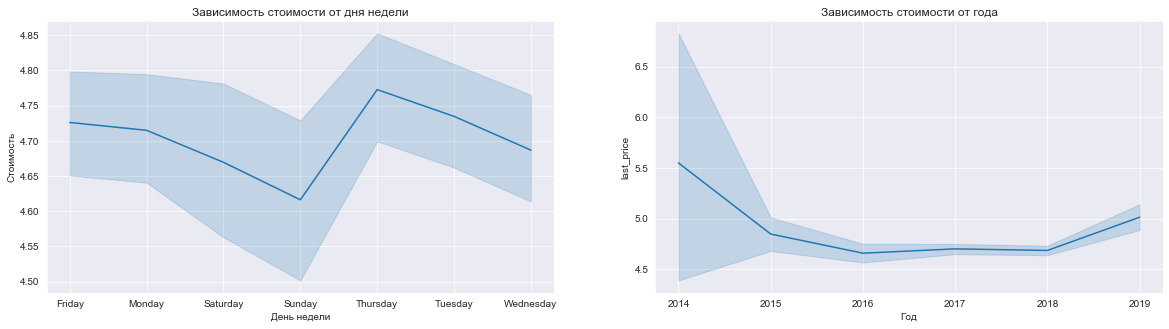

In [56]:
sns.set_style('darkgrid')
plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
sns.lineplot(data = data, x = 'weekday_exposition', y = 'last_price')
plt.title('Зависимость стоимости от дня недели')
plt.ylabel('Стоимость')
plt.xlabel('День недели')


plt.subplot(1,2,2)
sns.lineplot(data = data, x = 'year_exposition', y = 'last_price')
plt.title('Зависимость стоимости от года')
plt.xlabel('Год')


plt.show()

Можно сделать несколько выводов:
- Квартиры, которые выставили на продажу в воскресенье, дешевле, чем во все остальные дни.
- Квартиры, которые выставили на продажу в четверг, дороже, чем во все остальные дни.

- Дороже всего квартиры стоили в 2014 году, вероятно, из-за инфляции и кризиса того года.
- В 2016, 2017 и 2018 годах квартиры стоили примерно одинаково.

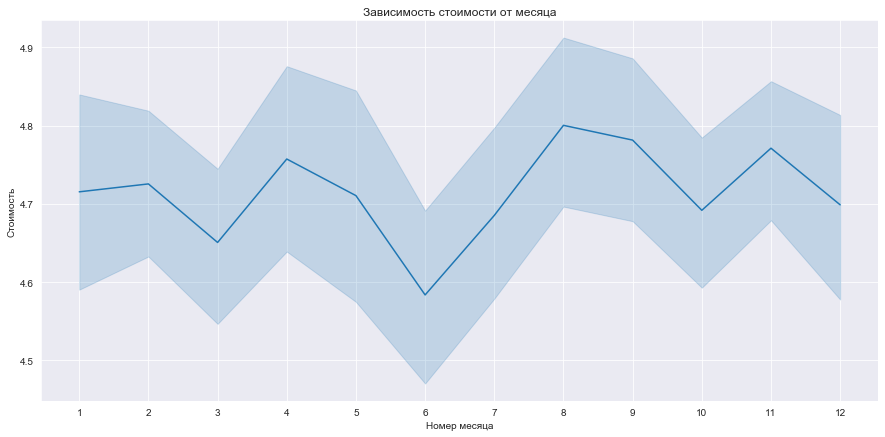

In [57]:
plt.figure(figsize = (15,7))
sns.lineplot(data = data, x = 'month_exposition', y = 'last_price')
plt.title('Зависимость стоимости от месяца')
plt.xticks(range(1,13))
plt.xlabel('Номер месяца')
plt.ylabel('Стоимость')

plt.show()

**Выводы:**
- Квартиры, выставленные на продажу в июне, дешевле, чем остальные.
- Квартиры, выставленные на проджау в августе, дороже, чем все остальные.

#### 5.2 Найдем ТОП10 населенных пунктов с наибольшим количеством объявлений и с самой высокой стоимостью жилья.

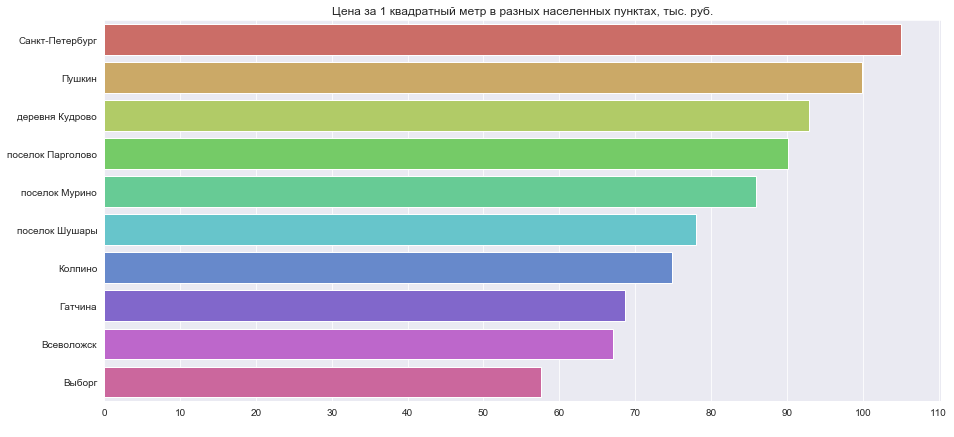

In [58]:
points = list(data.groupby('locality_name')['locality_name'].count().sort_values(ascending = False).head(10).index)
prices = data.query('locality_name in @points').groupby('locality_name')['price_per_metre'].mean().round().sort_values(ascending = False)


plt.figure(figsize = (15,7))
sns.barplot(x = prices/1000, y = prices.index, palette = 'hls')
plt.title('Цена за 1 квадратный метр в разных населенных пунктах, тыс. руб.')
plt.xticks(range(0,120,10))
plt.xlabel(' ')
plt.ylabel('')

plt.show()

**Вывод:**
- Как видно из графика, дороже всего жилье стоит в Санкт-Петербурге, Пушкине и деревне Кудрово.
- Причем разница между Санкт-Петербургом и Пушкиным не такая большая.
- Дешевле всего квартиры стоят в Выборге.

#### 5.3. Выясним, какая область входит в центр города в Санкт-Петербурге.

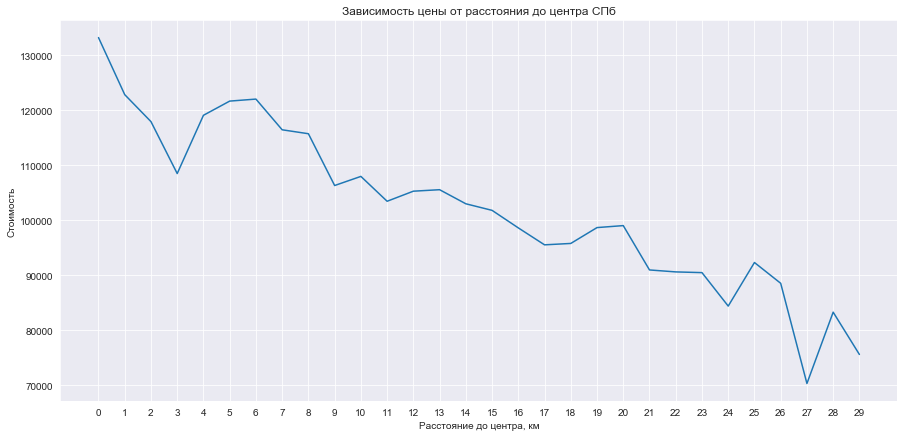

In [59]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest'] / 1000
spb = data.query('locality_name == "Санкт-Петербург"').round()
spb = spb.groupby('cityCenters_nearest_km')['price_per_metre'].mean().round().astype('int64')

plt.figure(figsize = (15,7))
sns.lineplot(x = spb.index, y = spb)
plt.title("Зависимость цены от расстояния до центра СПб")
plt.xlabel("Расстояние до центра, км")
plt.xticks(range(0,30,1))
plt.ylabel("Стоимость")

plt.show()

*Видим, что график стал резко изменяться при 3 км, значит примерный радиус центра города это 3 км.*

#### 5.4. Проанализируем отдельно квартиры в центре города, посмотрим на различия, по сравнению с остальной базой данных.

- Изучим такие параметры: `total_area`, `price_per_metre`, `rooms`, `ceiling_height`
- Выделим факторы, которые влияют на стоимость квартиры: `rooms`, `cityCenters_nearest_km`, `first_exposition_date`

In [60]:
spb = data[(data['locality_name'] == 'Санкт-Петербург') & (data['cityCenters_nearest_km'] <= 3)]

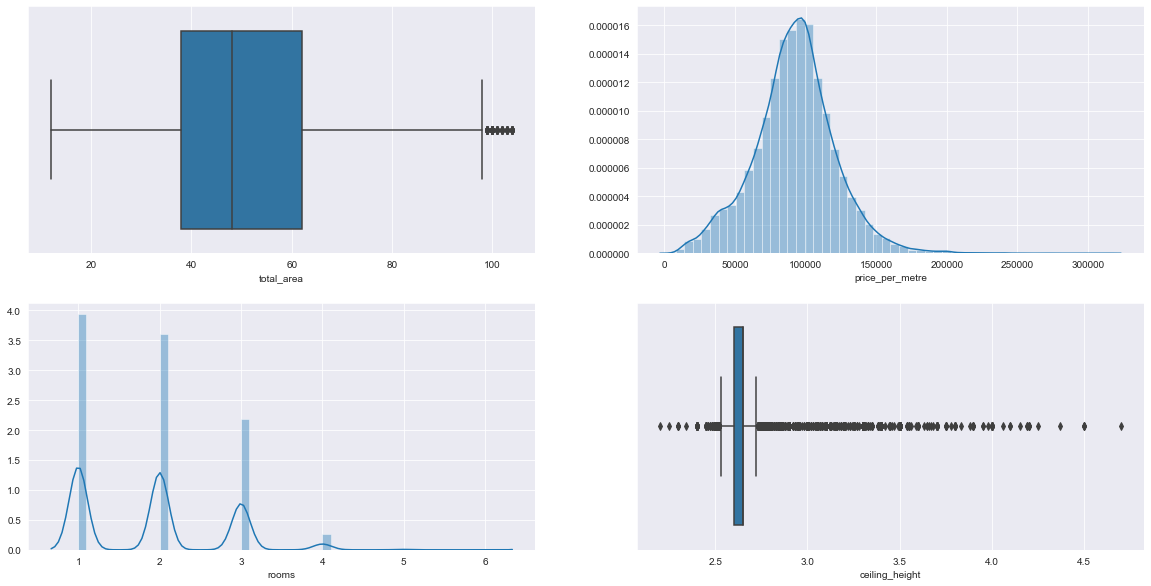

In [61]:
plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
sns.boxplot(data['total_area'])

plt.subplot(2,2,2)
sns.distplot(data['price_per_metre'])

plt.subplot(2,2,3)
sns.distplot(data['rooms'])

plt.subplot(2,2,4)
sns.boxplot(data['ceiling_height'])


plt.show()

- Чаще всего площадь квартиры в центре города небольшая, от 40 до 60 кв. м.
- Цена при этом высокая, в основном около 100к рублей.
- В основном квартиры 1-2х комнатные, реже 3х комнатные.
- Высота потолков 2.5-2.6 м.

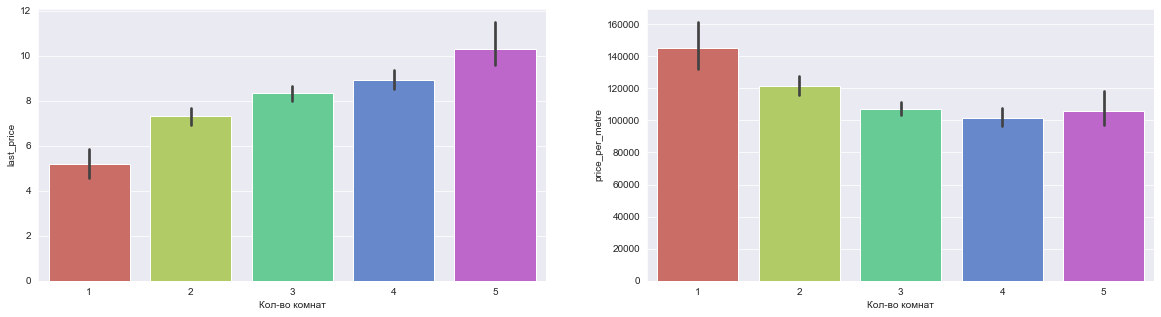

In [62]:
plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
sns.barplot(data = spb, x = 'rooms', y = 'last_price', palette = 'hls')
plt.xlabel('Кол-во комнат')

plt.subplot(1,2,2)
sns.barplot(data = spb, x = 'rooms', y = 'price_per_metre', palette = 'hls')
plt.xlabel('Кол-во комнат')

plt.show()

Можем пронаблюдать интересную зависимость, в среднем квартиры, чем больше в них комнат, тем они дороже, но цена за квадратный метр тем больше, чем меньше комнат. Довольно интересная зависимость.

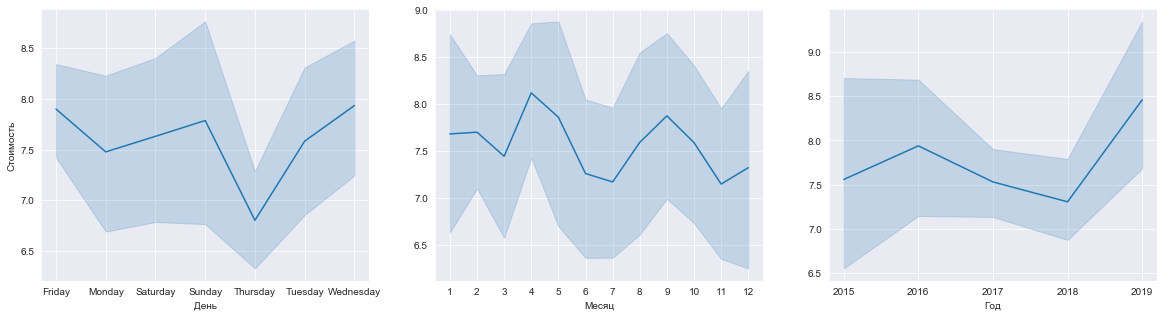

In [63]:
plt.figure(figsize = (20,5))

plt.subplot(1,3,1)
sns.lineplot(data = spb, x = 'weekday_exposition', y = 'last_price', palette = 'hls')
plt.xlabel('День')
plt.ylabel('Стоимость')

plt.subplot(1,3,2)
sns.lineplot(data = spb, x = 'month_exposition', y = 'last_price', palette = 'hls')
plt.xlabel('Месяц')
plt.xticks(range(1,13,1))
plt.ylabel(' ')

plt.subplot(1,3,3)
sns.lineplot(data = spb, x = 'year_exposition', y = 'last_price', palette = 'hls')
plt.xlabel('Год')
plt.xticks(range(2015,2020,1))
plt.ylabel(' ')

plt.show()

**Вывод:**

В среднем динамика почти не отличается от основого набора данных, разве что самые дорогие квартиры это те, что были выставлены в апреле, а не в августе.